In [398]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import glob
import dask.dataframe as dd
import seaborn as sns
import pickle
import pysam
import numpy as np
from collections import defaultdict
from sequencing_tools.viz_tools import color_encoder, okabeito_palette
from sequencing_tools.fastq_tools import reverse_complement
from sklearn.metrics import mean_squared_error
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize = 25)
plt.rc('ytick', labelsize = 25)
plt.rc('font', **{'family':'sans-serif',
                  'sans-serif':'Arial'})


def expected_nuc():
    fa = pysam.Fastafile('/stor/work/Lambowitz/ref/Mir9_2/MiRxplorer.fa')
    nuc_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for ref in fa.references:
        seq = fa[ref]
        read1 = seq[:15]
        read2 = reverse_complement(seq)[:15]
    
        for i, (b, rb) in enumerate(zip(read1, read2)):
            nuc_dict['read1'][i][b] += 1
            nuc_dict['read2'][i][rb] += 1
            
    dfs = []
    for read, read_dict in nuc_dict.items():
        for pos, pos_dict in read_dict.items():
            dfs.append(pd.DataFrame({'base': list(pos_dict.keys()),
                         'expected_base_count':list(pos_dict.values())})\
                .assign(end = read, pos = pos))
    return pd.concat(dfs) \
        .assign(expected_base_fraction = lambda d: d.groupby(['end','pos']).expected_base_count.transform(lambda x: x/x.sum()))

In [399]:
with open('model/weights.pkl', 'rb') as index:
    weights = pickle.load(index)

In [400]:
pd.Series(list(weights.values())).describe()

count    4096.000000
mean        3.343076
std         2.979530
min         0.249493
25%         1.051192
50%         2.626298
75%         4.632981
max        19.522538
dtype: float64

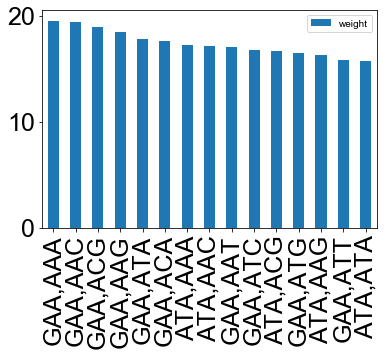

In [401]:
pd.DataFrame().from_dict(weights, orient='index', columns=['weight']) \
    .nlargest(15, 'weight')\
    .plot.bar()

In [433]:
NTA = '.no_NTA'
#NTA=''
df = pd.read_feather('/stor/work/Lambowitz/cdw2854/miRNA/new_NTT/MiR/mir_count{NTA}.feather'.format(NTA=NTA))
df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,mir,MTT1_corrected,MTT1_filter,MTT2_corrected,MTT2_filter,MTT3_corrected,MTT3_filter,NTC1_corrected,NTC1_filter,NTC2_corrected,...,NTT3_corrected,NTT3_filter,NTT6N_corrected,NTT6N_filter,NTTR1_corrected,NTTR1_filter,NTTR2_corrected,NTTR2_filter,NTTR3_corrected,NTTR3_filter
0,EBV-1-1,2125.418004,414.0,3643.260771,706.0,3779.113127,742.0,3406.294622,651.0,3500.594667,...,2859.558515,577.0,1669.976223,326.0,3572.278249,725.0,4988.135908,971.0,10559.562027,2074.0
1,EBV-1-2,6153.165763,8231.0,7373.799852,9934.0,8182.223235,11003.0,10332.396088,13723.0,8708.418260,...,11746.853316,15620.0,8440.674872,11354.0,5797.365886,7362.0,5142.293976,6941.0,6507.161362,8802.0
2,EBV-1-2-star,3524.539757,965.0,5240.140753,1337.0,7794.422755,2016.0,3702.421499,848.0,4899.177680,...,5393.134119,1406.0,3530.204298,1181.0,3043.505783,814.0,3191.158787,940.0,7347.723545,1861.0
3,EBV-1-3,1732.328774,1051.0,2873.027502,1735.0,2813.614839,1787.0,4233.827306,2516.0,3879.072450,...,3247.475622,1981.0,2091.442138,1459.0,803.284707,506.0,1529.782527,996.0,1805.505876,1045.0
4,EBV-1-3P,3608.305111,2339.0,3623.274164,2702.0,5162.708925,3481.0,2179.914880,1602.0,2739.317148,...,2771.452821,1785.0,3630.980056,2301.0,15260.090775,9932.0,12623.106106,8068.0,9844.605487,6163.0


In [434]:
ce = color_encoder()
mir_df = df\
    .set_index('mir')\
    .transform(lambda x: x/x.sum() * 1e6)\
    .reset_index()\
    .fillna(0)\
    .pipe(pd.melt, id_vars='mir', value_name = 'mir_count', var_name = 'sn')\
    .assign(correct = lambda d: np.where(d['sn'].str.contains('corrected'), 'Corrected', 'Uncorrected'))\
    .assign(color = lambda d: ce.fit_transform(d.correct)) 
mir_df.head()

,mir,sn,mir_count,correct,color
0,EBV-1-1,MTT1_corrected,123.179312,Corrected,#56B4E9
1,EBV-1-2,MTT1_corrected,356.608783,Corrected,#56B4E9
2,EBV-1-2-star,MTT1_corrected,204.265882,Corrected,#56B4E9
3,EBV-1-3,MTT1_corrected,100.397694,Corrected,#56B4E9
4,EBV-1-3P,MTT1_corrected,209.120532,Corrected,#56B4E9


In [435]:
rmse = mir_df \
    .groupby(['sn','correct','color'], as_index=False)\
    .agg({'mir_count': lambda x: mean_squared_error(np.log([1e6/962+1]*len(x)), 
                                                    np.log(x+1)) })\
    .assign(sn = lambda d: d.sn.str.extract('([A-Z]+[0-9]+)_'))\
    .pipe(pd.pivot_table, index=['sn'], columns = 'correct', values='mir_count') \
    .assign(Initial = lambda d: d.Uncorrected - d.Corrected) \
    .drop('Uncorrected', axis=1) \
#    .filter(['Corrected', 'Initial'])\
#    .rename(columns = {'Corrected':'Reweighted reads','Initial':'Intial reads'})

rmse

correct,Corrected,Initial
sn,,
MTT1,2.760966,0.783891
MTT2,2.657022,0.752553
MTT3,2.535959,0.700294
NTC1,2.940154,0.530003
NTC2,3.178679,-0.084159
NTC3,3.022688,-0.266781
NTT1,3.058533,1.184658
NTT2,2.944485,1.060220
NTT3,3.001639,1.153379


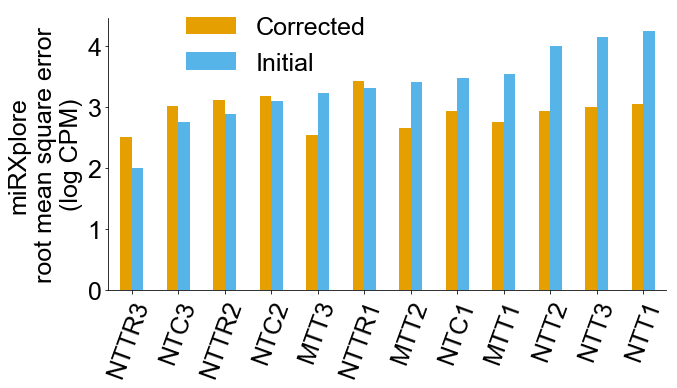

In [436]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot()
rmse_df = rmse\
    .assign(total = lambda d: d.sum(axis=1))\
    .sort_values('total')\
    .drop('total', axis=1)

if NTA ==  '.no_NTA':
    rmse_df['Initial'] = rmse_df['Corrected'] + rmse_df['Initial']
    stacked=False
else:
    stacked=True
rmse_df.plot.bar(stacked=stacked, ax = ax, color = okabeito_palette() )
sns.despine()
ax.legend(fontsize=25, frameon=False, loc='center', bbox_to_anchor=(0.3,0.9))
xts = []
for xt in ax.get_xticklabels():
    xts.append(xt.get_text().split('_')[0])
ax.set_xticklabels(xts, rotation=70, rotation_mode = 'anchor', ha='right')
ax.set_xlabel('')
ax.set_ylabel('miRXplore\nroot mean square error\n(log CPM)')
figname = '../figures/reweighted_rmse{NTA}.pdf'.format(NTA=NTA)
fig.savefig(figname, bbox_inches='tight')

In [437]:
nuc_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/miRNA/new_NTT/MiR/nuc_count{NTA}.feather'.format(NTA=NTA)) \
    .set_index('pos')\
    .pipe(lambda d: d[d.samplename.str.contains('^NTT[0-9]+')])\
    .assign(corrected = lambda d: np.where(d.samplename.str.contains('corrected'),
                                   'corrected',
                                   'uncorrected'))\
    .assign(samplename = lambda d: d.samplename.str.extract('^([A-Z]+[0-9]+)_'))\
    .pipe(dd.from_pandas, npartitions=24)\
    .groupby(['pos','end','corrected'])\
    .apply(lambda d: d\
               .assign(base_fraction = lambda d: d.base_count/d.base_count.sum())\
               .filter(regex='base'),
          meta = {'base':'f8', 'base_count':'f8', 'base_fraction':'f8'}) \
    .compute()
nuc_df.index = nuc_df.index.droplevel(-1)
nuc_df = nuc_df\
    .reset_index()
nuc_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,pos,end,corrected,base,base_count,base_fraction
0,0,read1,corrected,C,16577.993688,0.046356
1,0,read1,corrected,T,21037.059922,0.058824
2,0,read1,corrected,G,27001.783676,0.075503
3,0,read1,corrected,A,24235.096144,0.067767
4,0,read1,corrected,T,21094.071717,0.058984


In [438]:
expected_nuc().head()

,base,expected_base_count,end,pos,expected_base_fraction
0,T,402,read1,0,0.417879
1,A,284,read1,0,0.295218
2,G,122,read1,0,0.126819
3,C,154,read1,0,0.160083
0,A,356,read1,1,0.370062


In [439]:
corrected_df =  nuc_df\
    .groupby(['corrected','end','pos','base'], as_index=False)\
    .agg({'base_fraction':'sum'}) \
    .sort_values('pos')\
    .reset_index(drop=True)\
    .merge(expected_nuc(), on =['pos','base','end'], how='left' )\
    .assign(end = lambda d: d.end.str.capitalize())\
    .assign(corrected = lambda d: d.corrected.str.capitalize())\
    .assign(pos = lambda d: d.pos + 1)\
    .assign(normalized = lambda d: d.base_fraction / d.expected_base_fraction)\
    .assign(corrected = lambda d: d.corrected.map({'Corrected':'After reweighting','Uncorrected':'Before reweighting'}))\
    .assign(base = lambda d: d.base.str.replace('T','U')) \
    .query('pos < 7') \
    .assign(pos = lambda d: np.where(d.end=="Read2", 7-d.pos,d.pos))
corrected_df.head()

,corrected,end,pos,base,base_fraction,expected_base_count,expected_base_fraction,normalized
0,After reweighting,Read1,1,A,0.274318,284.0,0.295218,0.929204
1,Before reweighting,Read2,6,U,0.185305,220.0,0.228690,0.810288
2,Before reweighting,Read2,6,G,0.209130,179.0,0.186071,1.123928
3,Before reweighting,Read2,6,C,0.519405,205.0,0.213098,2.437403
4,Before reweighting,Read2,6,A,0.086160,358.0,0.372141,0.231525


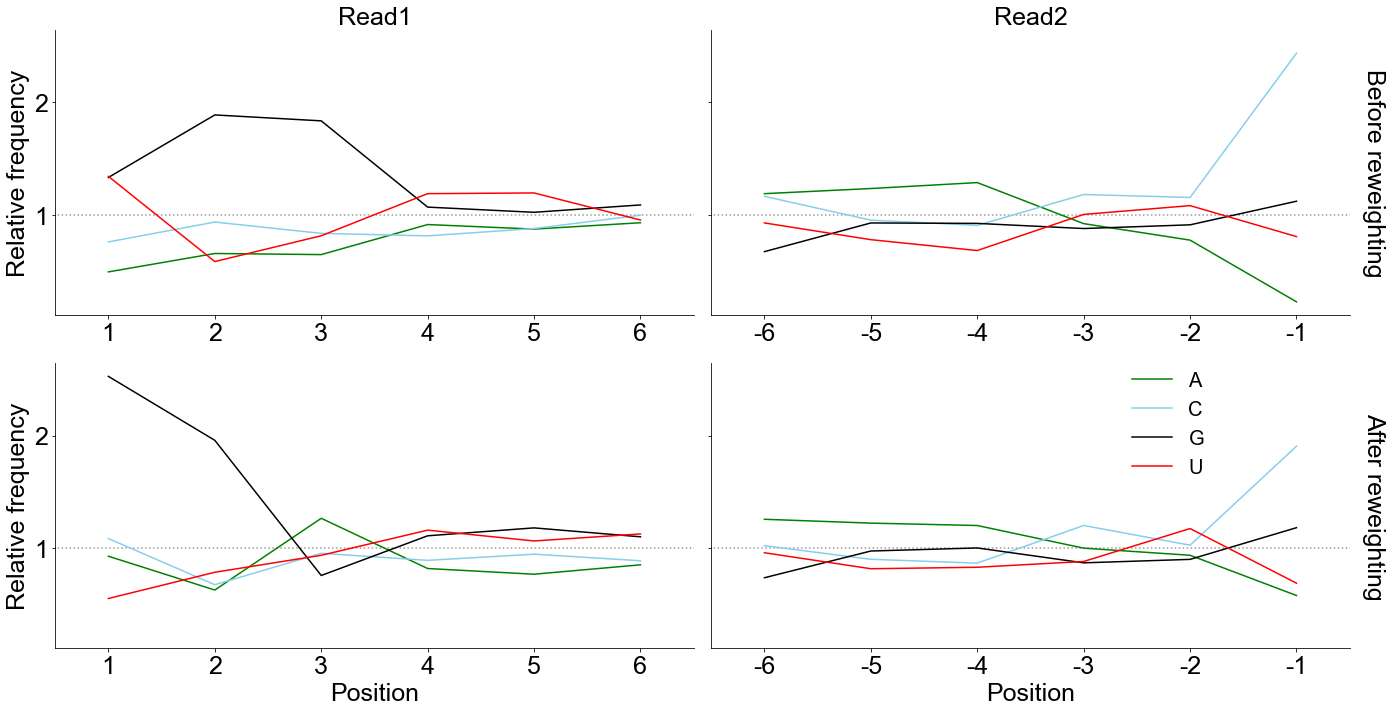

In [440]:
p = sns.FacetGrid(data=corrected_df, row='corrected', hue = 'base',
             palette = ['green','skyblue','black', 'red'],
             col_order = ['Read1','Read2'],
             row_order = ['Before reweighting', 'After reweighting'],
             hue_order = ['A','C','G','U'],
             col= 'end',aspect=2, height=5,
             sharex=False,
             margin_titles=True)
p.map(plt.plot, 'pos', 'normalized')
for i, ax in enumerate(p.fig.axes):
    ax.hlines(xmin=0, xmax=16, y=1,linestyle=':', color='grey', alpha=0.8)
    if i in {1,3}:
        ax.set_xticklabels(range(-7,0))
[plt.setp(ax.texts, text="") for ax in p.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
p.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=25)
p.add_legend(fontsize=20,title='', bbox_to_anchor=(0.8,0.4))
p.set_axis_labels('Position', 'Relative frequency')
p.set(xlim=(.5,6.5))
figname = '../figures/reweighted_nucleotide{NTA}.pdf'.format(NTA=NTA)
p.savefig(figname, bbox_inches='tight')

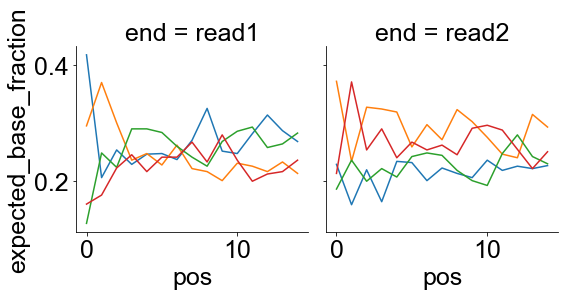

In [393]:
p = sns.FacetGrid(data = expected_nuc(),
             hue = 'base', col = 'end', height=4)
p.map(plt.plot, 'pos','expected_base_fraction')